In [175]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer


# 1. Analiza i priprema podataka 

In [176]:
PATH_TO_PARQUET = Path(r"C:/Users/Ki/OneDrive - fer.hr/Documents/GitHub/ML-Projekt-Vicuna/btc_historical_price.parquet")

if not PATH_TO_PARQUET.exists():
    raise FileNotFoundError(f"Datoteka nije pronađena: {PATH_TO_PARQUET}")

df = pd.read_parquet(PATH_TO_PARQUET)
df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")
print("Veličina skupa:", df.shape)
df.head()

Veličina skupa: (50676, 6)


,Open,High,Low,Close,Trades,Volume
Date,,,,,,
2020-01-01 01:00:00+00:00,7189.43,7190.52,7170.15,7171.55,3688.0,2449.049
2020-01-01 02:00:00+00:00,7171.43,7225.00,7171.10,7210.24,6635.0,3865.038
2020-01-01 03:00:00+00:00,7210.38,7239.30,7206.46,7237.99,5120.0,3228.365
2020-01-01 04:00:00+00:00,7237.41,7239.74,7215.00,7221.65,4143.0,2513.307
2020-01-01 05:00:00+00:00,7221.80,7225.41,7211.22,7213.86,1966.0,1176.666


In [177]:
idx = df.index
full_range = pd.date_range(start=idx.min(), end=idx.max(), freq="H")
missing = full_range.difference(idx)
duplicated = idx[idx.duplicated()]

print("Početak:", idx.min())
print("Kraj:", idx.max())
print(f"Broj nedostajućih sati: {len(missing)}")
print(f"Broj duplikata: {len(duplicated)}")

Početak: 2020-01-01 01:00:00+00:00
Kraj: 2025-10-12 12:00:00+00:00
Broj nedostajućih sati: 0
Broj duplikata: 0


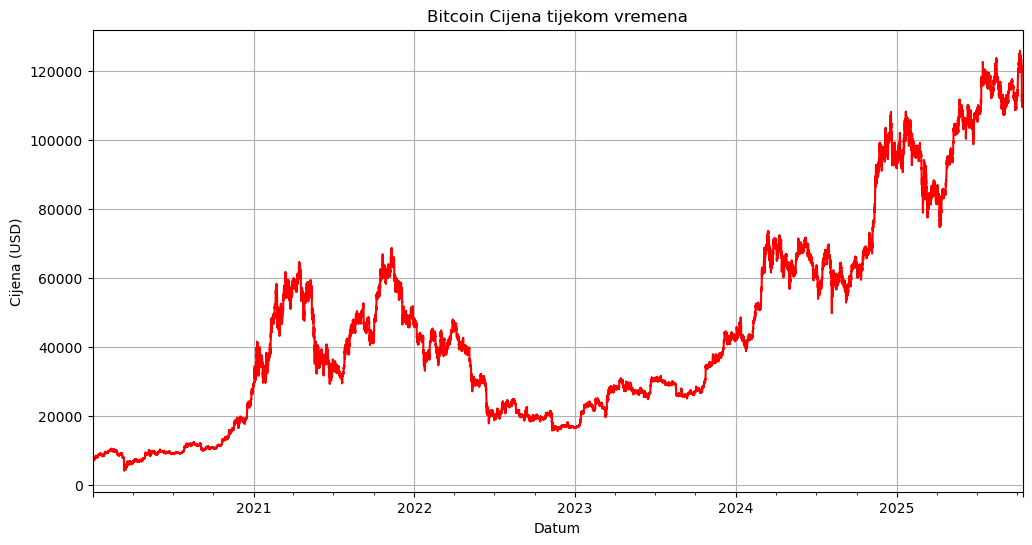

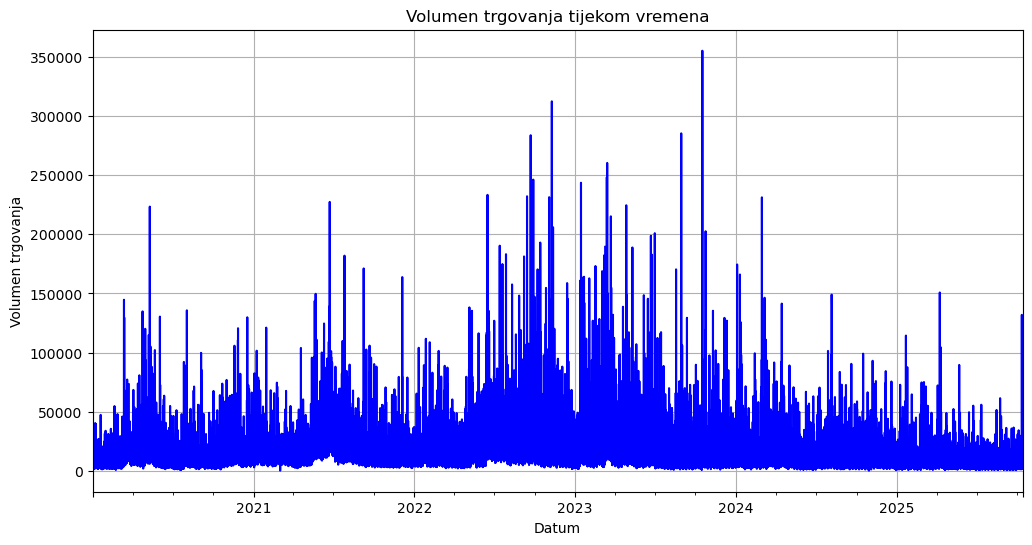

In [178]:
plt.figure(figsize=(12, 6))
df['Close'].plot(title='Bitcoin Cijena tijekom vremena', color = 'red')
plt.xlabel('Datum')
plt.ylabel('Cijena (USD)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
df['Volume'].plot(title='Volumen trgovanja tijekom vremena', color = 'blue')
plt.xlabel('Datum')
plt.ylabel('Volumen trgovanja')
plt.grid(True)
plt.show()



In [179]:

# osnovni povrati
df["return_t_1"] = np.log(df["Close"] / df["Close"].shift(1))
df["return_t_5"] = np.log(df["Close"] / df["Close"].shift(5))
df["return_t_10"] = np.log(df["Close"] / df["Close"].shift(10))

# target varijabla – budući povrat
df["target"] = df["return_t_1"].shift(-1)

# binarna klasa: rast/pad samo ako je promjena > 0.1 %
threshold = 0.001
df["target_cls"] = np.where(df["target"] > threshold, 1,
                            np.where(df["target"] < -threshold, 0, np.nan))

# volatilnost
df["volatility_5"] = df["return_t_1"].rolling(window=5*24).std()
df["volatility_10"] = df["return_t_1"].rolling(window=10*24).std()
df["volatility_20"] = df["return_t_1"].rolling(window=20*24).std()

# pokretni prosjeci
df["sma_5"] = df["Close"].rolling(window=5).mean()
df["sma_20"] = df["Close"].rolling(window=20).mean()
df["ema_10"] = df["Close"].ewm(span=10, adjust=False).mean()

# volumen i omjeri cijena
df["volume_ratio_10"] = df["Volume"] / df["Volume"].rolling(window=10).mean()
df["ratio_high_low"] = df["High"] / df["Low"]
df["ratio_close_open"] = df["Close"] / df["Open"]

# momentum (koristi samo prošlost)
df["momentum"] = df["Close"].shift(1) - df["Close"].shift(6)

# vremenske značajke
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month


In [180]:
# RSI
def compute_RSI(series, window=14):
    delta = series.diff(1)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100 - (100 / (1 + rs))

df["rsi_14"] = compute_RSI(df["Close"], 14)

# MACD i Bollinger
ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
df["macd"] = ema_12 - ema_26
df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

window = 20
rolling_mean = df["Close"].rolling(window).mean()
rolling_std = df["Close"].rolling(window).std()
df["bb_high"] = rolling_mean + (2 * rolling_std)
df["bb_low"] = rolling_mean - (2 * rolling_std)

# Drop nan
df = df.dropna(subset=["target_cls"]).copy()
print("Broj redaka nakon čišćenja:", len(df))

Broj redaka nakon čišćenja: 38256


# 2. Modeliranje i evaluacija

In [181]:
split_index = int(len(df) * 0.8)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

x_train = train.drop(columns=["target", "target_cls"])
y_train = train["target_cls"]
x_test = test.drop(columns=["target", "target_cls"])
y_test = test["target_cls"]

print("Train:", x_train.shape, "| Test:", x_test.shape)
print("Zadnji datum train:", train.index.max())
print("Prvi datum test:", test.index.min())

Train: (30604, 27) | Test: (7652, 27)
Zadnji datum train: 2024-08-04 04:00:00+00:00
Prvi datum test: 2024-08-04 05:00:00+00:00


In [182]:
def winsorize(s, lo=0.01, hi=0.99):
    ql, qh = s.quantile(lo), s.quantile(hi)
    return s.clip(ql, qh)

for col in x_train.columns:
    x_train[col] = winsorize(x_train[col])
    x_test[col] = winsorize(x_test[col])

In [183]:
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # popunjava NaN
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
y_prob = pipe.predict_proba(x_test)[:, 1]

hit = accuracy_score(y_test, y_pred)
print(f"RandomForest HIT={hit:.3f}")


RandomForest HIT=0.528


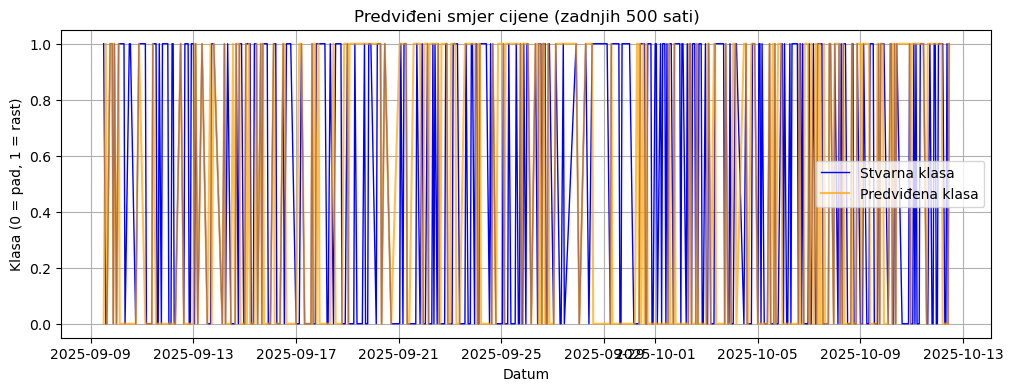

In [ ]:
subset = y_test[-500:] 
pred_subset = y_pred[-500:]

plt.figure(figsize=(12, 4))
plt.plot(subset.index, subset, label="Stvarna klasa", color="blue", linewidth=1)
plt.plot(subset.index, pred_subset, label="Predviđena klasa", color="orange", alpha=0.7)
plt.xlabel("Datum")
plt.ylabel("Klasa (0 = pad, 1 = rast)")
plt.title("Predviđeni smjer cijene (zadnjih 500 sati)")
plt.legend()
plt.grid(True)
plt.show()


In [185]:
window = int(len(df) * 0.2)
hits = []

for start in range(0, len(df) - 2 * window, window):
    tr = df.iloc[start:start + window]
    te = df.iloc[start + window:start + 2 * window]

    xtr, ytr = tr.drop(columns=["target", "target_cls"]), tr["target_cls"]
    xte, yte = te.drop(columns=["target", "target_cls"]), te["target_cls"]

    pipe.fit(xtr, ytr)
    yhat = pipe.predict(xte)
    hits.append((yhat == yte).mean())

print("Prosječni HIT po vremenskim prozorima:", np.mean(hits))

Prosječni HIT po vremenskim prozorima: 0.5223826950725395
